<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP4_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Difference in 2D

1. Finite Difference solver for the 2D Poisson problem:

$-\Delta u=f \quad \in \Omega=(a,b)^2$

$u|_{\partial\Omega}=0$

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 2D FD algebric system

$N=3$

$h=1/N$

Remember how the stencil looks like, there is a -4 in the place we are centered and in the 4 neighbours there is a 1

$$
\begin{pmatrix}
-4 & 1 & ... & 1 & ...\\
1 & -4 & 1 & ... & 1\\
... & 1 & -4 & 1 & ...\\
1 & ... & 1 & -4 & 1 
\end{pmatrix}
$$

with distance between the 1s=N+1 and all the ...=0

In [12]:
omega = [0, 1]
N = 3

h = (omega[1]-omega[0])/N
x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)

X = X.flatten()
Y = Y.flatten()

print(X)

print(Y)

[0.         0.33333333 0.66666667 1.         0.         0.33333333
 0.66666667 1.         0.         0.33333333 0.66666667 1.
 0.         0.33333333 0.66666667 1.        ]
[0.         0.         0.         0.         0.33333333 0.33333333
 0.33333333 0.33333333 0.66666667 0.66666667 0.66666667 0.66666667
 1.         1.         1.         1.        ]


In [13]:
def FD2D(omega,N,rhs):
  # FD system matrix and rhs in omega^2 for
  # poisson equation homogeneous Dirichlet bc
  # uniform grid in sparse CSR format
  # with Nx = Ny = N

  # x and y axis grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)
  y = x
  # 2-dim grid
  X, Y = np.meshgrid(x,y)
  X = X.flatten()
  Y = Y.flatten()

  # compute rhs
  F = rhs(X,Y)

  # compute system matrix
  # -(1/h^2) (U_{i,j-1}  +U_{i-1,j})     - 4 * U_{i,j}  +   U_{i+1,j} + U_{i,j+1} )
  coefs = [-1*np.ones((N+1)*(N)) ,-1*np.ones((N+1)*(N+1)-1),4*np.ones((N+1)*(N+1)),-1*np.ones((N+1)*(N+1)-1),-1*np.ones((N+1)*(N))]
  A = sp.diags(coefs, [-(N+1), -1, 0, 1, N+1],format="csr")

  # Implement boundary conditions
  for i in range(N+1):
    # y = a
    A[i,A[i].nonzero()] = 0; A[i,i] = 1; F[i] = 0
    # y = b
    j = (N+1) * N + i
    A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = 0

  for i in range(1,N):
    # x = a
    j = i * (N+1)
    A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = 0
    # x = b
    j = i * (N+1) + N
    A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = 0

  return (1./h**2) * A, F

Define FD problem and solve with $(a,b)=(0,
pi)$ and

$u(x,y)=sin(x)*sin(y)$

hence

$f=2* sin(x)*sin(y)$

In [14]:
# Problem data
omega = [0, np.pi]
N=10
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
u = lambda x, y : np.sin(x) * np.sin(y)

# call function computing FD system
A, F = FD2D(omega,N,rhs)

# solve
uh = spsolve(A,F)


Plot solution

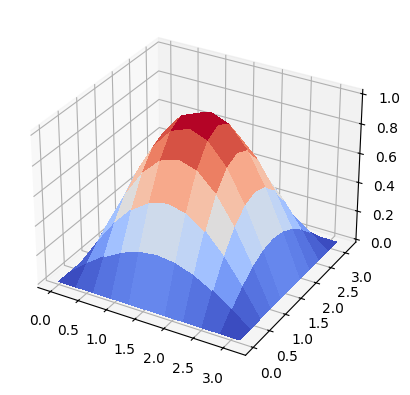

In [15]:
# Prepare data for plotting
x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)
Uh = uh.reshape((N+1),(N+1))

# Plot the solution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

Compute discrete max norm error

In [16]:
# compute exact sol
U = u(X,Y)

# Print discrete error
print(np.max(np.max(np.abs(U-Uh))))

0.008265416966227512


**Exercise 1**: Run a series of experiments each time halfing the mesh size to each time computing the error and the EOC

In [17]:
err=np.zeros(10)
NN=np.zeros(10)
for i in range(1,11):
    N=2*i
    NN[i-1]=N
    # Problem data
    omega = [0, np.pi]
    rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
    u = lambda x, y : np.sin(x) * np.sin(y)

    # call function computing FD system
    A, F = FD2D(omega,N,rhs)

    # solve
    uh = spsolve(A,F)

    x = np.linspace(omega[0],omega[1],N+1)
    y = x
    X,Y=np.meshgrid(x,y)
    Uh = uh.reshape((N+1),(N+1))
    
    # compute exact sol
    U = u(X,Y)

    # Print discrete error
    err[i-1]=np.max(np.max(np.abs(U-Uh)))
    print(np.max(np.max(np.abs(U-Uh))))

0.23370055013616975
0.05302928754551495
0.0231629187630793
0.012950746721879458
0.008265416966227512
0.0057312032488217035
0.0042068466840667895
0.0032189644400806294
0.002542349500671337
0.0020587067645327917


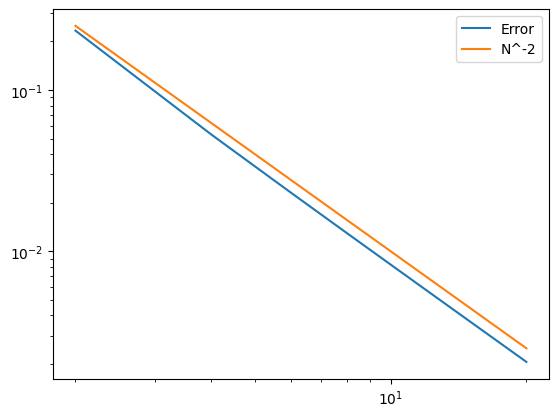

In [18]:
import matplotlib.pyplot

matplotlib.pyplot.loglog(NN,err, label='Error')
matplotlib.pyplot.loglog(NN,NN**(-2), label='N^-2')
matplotlib.pyplot.legend()

**Exercise 2**: Generalise the FD2D routine to assemble more general elliptic problems. For instance, solve

-$\alpha \Delta u + {\bf b}\cdot \nabla u + c u =f\, $ in $\, \Omega$,

with homogeneous Dirichlet and nonhomogeneous Dirichlet boundary conditions.

Write a program to test your routine and check EOC.

In [19]:
def FD2D(omega,N,rhs, alpha=0.5, b=[0,0], c=0., dbc=[0,0]):
    # FD system matrix and rhs in omega^2 for
    # elliptic with homogeneus Dirichlet/ non-homogeneus Dirichlet bc
    # uniform grid in sparse CSR format
    # with Nx = Ny = N
    
    # x and y axis grid
    h = (omega[1]-omega[0])/N
    x = np.linspace(omega[0],omega[1],N+1)
    y = x
    # 2-dim grid
    X, Y = np.meshgrid(x,y)
    X = X.flatten()
    Y = Y.flatten()
    
    # compute rhs
    F = rhs(X,Y)

    a=-alpha/h**2
    bb=b[0]/(2*h)
    cc=-b[1]/(2*h)

    #bc
    u_l=dbc[0]
    u_r=dbc[1]
    
    # compute system matrix
    # terms related to reaction a
    A_d = -4*a*np.ones((N+1)**2)+c*np.ones((N+1)**2)
    A_l = a*np.ones((N+1)*N)
    A_r = a*np.ones((N+1)*N)
    A_up = a*np.ones((N+1)*(N+1)-1)
    A_do = a*np.ones((N+1)*(N+1)-1)
    # terms related to convection b
    C_l = -bb*np.ones((N+1)*N)
    C_r = bb*np.ones((N+1)*N)
    C_up = cc*np.ones((N+1)*(N+1)-1)
    C_do = -cc*np.ones((N+1)*(N+1)-1)

    # Assembly
    A=sp.diags([A_l+C_l,A_do+C_do,A_d,A_up+C_up,A_r+C_r], 
               [-(N+1), -1, 0, 1, N+1],format="csr")
    
    # add bc
    for i in range(N+1):
        # y = a
        A[i,A[i].nonzero()] = 0; A[i,i] = 1; F[i] = u_l
        # y = b
        j = (N+1) * N + i
        A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = u_r
    
    for i in range(1,N):
        # x = a
        j = i * (N+1)
        A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = u_l
        # x = b
        j = i * (N+1) + N
        A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = u_r
    
    return A, F

In [55]:
# test it
omega = [0, np.pi]
N=10
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
alpha=1.
b=[0,0]
c=0.
dbc=[0,0]
h = (omega[1]-omega[0])/N

no_expe=10

# solution
u=lambda x,y: np.sin(x)*np.sin(y)

# fd system
A, F = FD2D(omega,N,rhs,alpha,b,c,dbc)

uh = spsolve(A,F)

# grid
x = np.linspace(omega[0],omega[1],N+1)
y = x
X,Y=np.meshgrid(x,y)
Uh = uh.reshape((N+1),(N+1))
# erroe
U = u(X,Y)
err=np.max(np.max(np.abs(U-Uh)))

for i in range (no_expe-1):
    N=2*(i+1)
    # fd system
    A, F = FD2D(omega,N,rhs,alpha,b,c,dbc)
    # solve
    uh_loop = spsolve(A,F)
    # grid
    x = np.linspace(omega[0],omega[1],N+1)
    y = x
    X,Y=np.meshgrid(x,y)
    Uh_loop = uh_loop.reshape((N+1),(N+1))
    # exact solution
    U = u(X,Y)
    # error
    err_loop=np.max(np.max(np.abs(U-Uh_loop)))
    h_loop = (omega[1]-omega[0])/N
    eoc = np.log(err/err_loop)/np.log(h/h_loop)

    print(eoc)

    h = h_loop
    err = err_loop

2.0764767563355053
2.1397998593099845
2.042818651367605
2.0209782884436356
2.0124859809964337
2.0082906614195863
2.005908369702625
2.0044249539882797
2.003438358597724


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


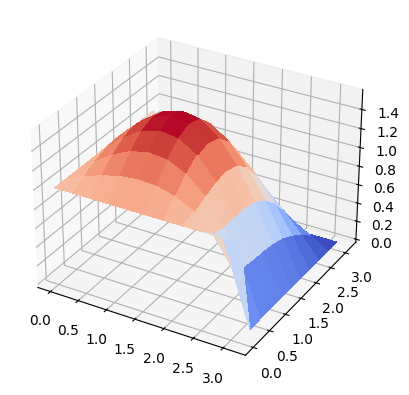

In [58]:
omega = [0, np.pi]
N=10
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
alpha=1.
b=[0,0]
c=0.
dbc=[1,0]

A, F = FD2D(omega,N,rhs,alpha,b,c,dbc)
uh = spsolve(A,F)
x=np.linspace(omega[0],omega[1],N+1)
y=x

X,Y=np.meshgrid(x,y)
Uh = uh.reshape((N+1),(N+1))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface = ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)